<b> HR Analytics Experiment </b>

HR analytics experiment to practice data cleaning, pre-processing, etc. etc.

This notebook will cover practice in analyzing categorical data for logistic regression and other interesting stuff I might want to play around with.

In [1]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import numpy as np 
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#is there a way to do this with something like a for-loop??
emp_survey = pd.read_csv('employee_survey_data.csv')
g_data = pd.read_csv('general_data.csv')
in_time = pd.read_csv('in_time.csv')
m_survey = pd.read_csv('manager_survey_data.csv')
out_time = pd.read_csv('out_time.csv')

Now that our data's loaded, we can take a closer look

In [4]:
emp_survey.count()

EmployeeID                 4410
EnvironmentSatisfaction    4385
JobSatisfaction            4390
WorkLifeBalance            4372
dtype: int64

In [5]:
emp_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [6]:
m_survey.count()

EmployeeID           4410
JobInvolvement       4410
PerformanceRating    4410
dtype: int64

In [7]:
m_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [8]:
g_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [9]:
g_data.count()

Age                        4410
Attrition                  4410
BusinessTravel             4410
Department                 4410
DistanceFromHome           4410
Education                  4410
EducationField             4410
EmployeeCount              4410
EmployeeID                 4410
Gender                     4410
JobLevel                   4410
JobRole                    4410
MaritalStatus              4410
MonthlyIncome              4410
NumCompaniesWorked         4391
Over18                     4410
PercentSalaryHike          4410
StandardHours              4410
StockOptionLevel           4410
TotalWorkingYears          4401
TrainingTimesLastYear      4410
YearsAtCompany             4410
YearsSinceLastPromotion    4410
YearsWithCurrManager       4410
dtype: int64

Okay, so basically we have 4410 rows but there are missing values in our data. First of all, let's join the dataframes because they have a common column, which is employee ID. Let's not bother with the time in and time out values for now.

In [10]:
m_table = pd.merge(g_data, m_survey, on = 'EmployeeID')
x_table = pd.merge(m_table, emp_survey, on = 'EmployeeID')
# lol is there a more efficient way of doing this

In [11]:
x_table.count()

Age                        4410
Attrition                  4410
BusinessTravel             4410
Department                 4410
DistanceFromHome           4410
Education                  4410
EducationField             4410
EmployeeCount              4410
EmployeeID                 4410
Gender                     4410
JobLevel                   4410
JobRole                    4410
MaritalStatus              4410
MonthlyIncome              4410
NumCompaniesWorked         4391
Over18                     4410
PercentSalaryHike          4410
StandardHours              4410
StockOptionLevel           4410
TotalWorkingYears          4401
TrainingTimesLastYear      4410
YearsAtCompany             4410
YearsSinceLastPromotion    4410
YearsWithCurrManager       4410
JobInvolvement             4410
PerformanceRating          4410
EnvironmentSatisfaction    4385
JobSatisfaction            4390
WorkLifeBalance            4372
dtype: int64

We seem to have holes in our data. Let's see which columns have missing information

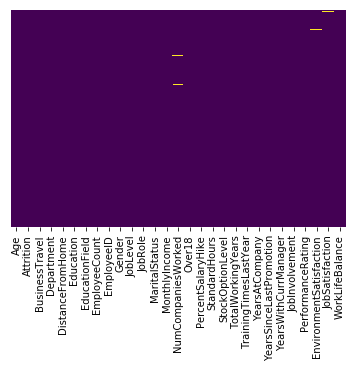

In [12]:
sns.heatmap(x_table.isna(),yticklabels=False,cbar=False,cmap='viridis')

Seems like there isn't too much information missing. The yellow bars represent rows with missing data.

Alright! x_table basically now has all the information from the three different files we loaded. Let's deal with those NA values first. Let's look at where those NA values are.

In [13]:
y_table = x_table.dropna()

In [14]:
y_table.count()

Age                        4300
Attrition                  4300
BusinessTravel             4300
Department                 4300
DistanceFromHome           4300
Education                  4300
EducationField             4300
EmployeeCount              4300
EmployeeID                 4300
Gender                     4300
JobLevel                   4300
JobRole                    4300
MaritalStatus              4300
MonthlyIncome              4300
NumCompaniesWorked         4300
Over18                     4300
PercentSalaryHike          4300
StandardHours              4300
StockOptionLevel           4300
TotalWorkingYears          4300
TrainingTimesLastYear      4300
YearsAtCompany             4300
YearsSinceLastPromotion    4300
YearsWithCurrManager       4300
JobInvolvement             4300
PerformanceRating          4300
EnvironmentSatisfaction    4300
JobSatisfaction            4300
WorkLifeBalance            4300
dtype: int64

That might have been hasty, although removing a couple of rows from a sample of 4000+ isn't so bad. We can explore alternatives such as imputing later on. We can be sure we won't run into problems for now since we don't have missing values in our data anymore. 

Let's do some exploratory analysis to a get a better understanding of our data.

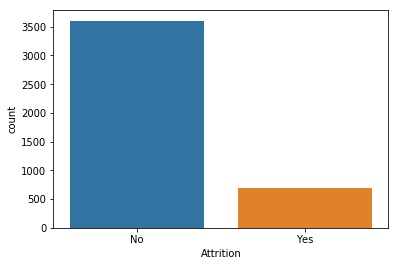

In [15]:
sns.countplot(x='Attrition', data = y_table)

Seems like they're losing quite a few employees every year.

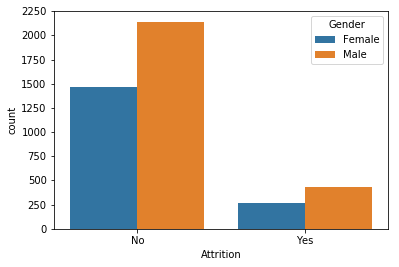

In [16]:
sns.countplot(x='Attrition', hue = 'Gender', data = y_table)

You can use the hue argument to divide the count across categories. In this case, I divided them into male and female to check if theres any difference in male and female employee attrition rates.

Might be the case that there are just more male employees compared to females in this firm. Can't really draw any meaningful analysis from this.

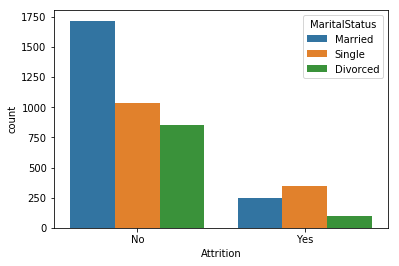

In [17]:
sns.countplot(x='Attrition', hue = 'MaritalStatus', data = y_table)

Seems like single people are more adventurous even in their careers or maybe married people prefer stability because they have families to support. Yeah.

Histograms are also useful if you want to check the distribution of certain things you might want to check first like age or monthly income.

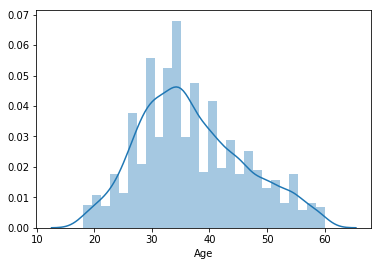

In [18]:
sns.distplot(y_table['Age'])

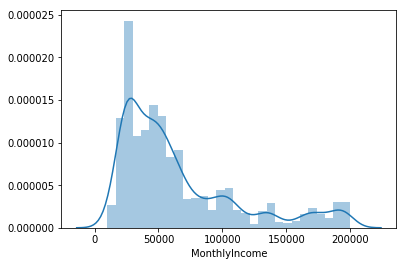

In [19]:
sns.distplot(y_table['MonthlyIncome'])

Makes sense so far. It's worth noting that a lot of data that you'll end up using in practice won't be normally distributed, and will more often be incredibly skewed like the histogram of monthly income above. 

<b> Logistic Regression </b>

Logistic Regression can be used as a means of classification. Basically, you get lots of information to predict discrete categories instead of continuous values.

Does this person have cancer? Is this person likely to resign? Is this person likely to default on his/her loan? Logistic regression lets us find patterns in our data to answer these questions. Cool, right?

First of all, let's check what data types we're dealing with.

In [20]:
y_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 29 columns):
Age                        4300 non-null int64
Attrition                  4300 non-null object
BusinessTravel             4300 non-null object
Department                 4300 non-null object
DistanceFromHome           4300 non-null int64
Education                  4300 non-null int64
EducationField             4300 non-null object
EmployeeCount              4300 non-null int64
EmployeeID                 4300 non-null int64
Gender                     4300 non-null object
JobLevel                   4300 non-null int64
JobRole                    4300 non-null object
MaritalStatus              4300 non-null object
MonthlyIncome              4300 non-null int64
NumCompaniesWorked         4300 non-null float64
Over18                     4300 non-null object
PercentSalaryHike          4300 non-null int64
StandardHours              4300 non-null int64
StockOptionLevel           4300 non-n

<b> Converting Categorical Features </b>

We'll need to convert our categories into something the computer can understand, otherwise the algorithm won't be able to take them in as inputs. That's why we need to turn them into dummy variables!

<b> Dummy Variables </b>

Dummy variables are basically category columns made of 0's and 1's. For example, "Gender" can become one column called "Male" where 1 indicates that the data point is male, and 0 if otherwise. The computer cannot read the columns if our inputs were "Male" and "Female".

Likewise, if I did this with "MaritalStatus", it can become two columns: Married, and Single. 0 values on both columns will indicate that the data point is Divorced. Basically, the number of columns a dummy conversion will output is always (no. of features - 1)


In [21]:
sex = pd.get_dummies(y_table['Gender'],drop_first = True)
ms = pd.get_dummies(y_table['MaritalStatus'],drop_first = True)
att = pd.get_dummies(y_table['Attrition'], drop_first = True)
bt = pd.get_dummies(y_table['BusinessTravel'], drop_first = True)
dep = pd.get_dummies(y_table['Department'], drop_first = True)
o18 = pd.get_dummies(y_table['Over18'], drop_first = True)
jr = pd.get_dummies(y_table['JobRole'], drop_first = True)
ef = pd.get_dummies(y_table['EducationField'], drop_first = True)

I've created dataframes out of our categorical features using get_dummies from pandas. Let's check out how those columns look like.

In [22]:
sex.head()

,Male
0,0
1,0
2,1
3,1
4,1


In [23]:
ms.head()

,Married,Single
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1


Cool! All that's left is to attach these to our original dataframe.

In [24]:
z_table = pd.concat([y_table, ms, sex, att, bt, dep, jr, ef], axis = 1)

In [25]:
z_table.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'Married', 'Single', 'Male',
       'Yes', 'Travel_Frequently', 'Travel_Rarely', 'Research & Development',
       'Sales', 'Human Resources', 'Laboratory Technician', 'Manager',
       'Manufacturing Director', 'Research Director', 'Research Scientist',
       'Sales Executive', 'Sales Representative', 'Life Sciences', 'Marketing',
       'Medical', 'Other', 'Technical Degree'],
      dtype='object')

Wonderful. We now have a ridiculously massive dataframe. By checking the columns in y_table, we're now sure that we were able to concatenate tables ms and sex to our original dataframe.

Before we get to regression, we still have to remove the non-numeric values in our table! Those need to be dropped from the dataframe too.

In [26]:
reg_df = z_table.drop(['Gender','MaritalStatus','Attrition','BusinessTravel','Department','Over18','JobRole','EducationField'],axis=1)

Notice we converted all the 'object' type columns and dropped them after getting their dummies. Let's check our new dataframe to be sure.

In [27]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 42 columns):
Age                        4300 non-null int64
DistanceFromHome           4300 non-null int64
Education                  4300 non-null int64
EmployeeCount              4300 non-null int64
EmployeeID                 4300 non-null int64
JobLevel                   4300 non-null int64
MonthlyIncome              4300 non-null int64
NumCompaniesWorked         4300 non-null float64
PercentSalaryHike          4300 non-null int64
StandardHours              4300 non-null int64
StockOptionLevel           4300 non-null int64
TotalWorkingYears          4300 non-null float64
TrainingTimesLastYear      4300 non-null int64
YearsAtCompany             4300 non-null int64
YearsSinceLastPromotion    4300 non-null int64
YearsWithCurrManager       4300 non-null int64
JobInvolvement             4300 non-null int64
PerformanceRating          4300 non-null int64
EnvironmentSatisfaction    4300 non-null fl

We have a new problem here. 

get_dummies converted a bunch of columns and named them 'yes', and now we have a bunch of columns with the same name and no way to identify where they came from. Let's be more careful this time.

This is why I assign a new variable when making updated tables instead of using inplace = True. We can backtrack our progress with all this dummy variable conversion by just using y_table instead.

In [28]:
y_table.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance'],
      dtype='object')

See? Completely untouched. Let's try this again. Let's be a bit more careful now and rename our columns as we go along to avoid some confusion. We just need to check out our new dataframes from what get_dummies output.

In [29]:
att.head()

,Yes
0,0
1,1
2,0
3,0
4,0


There you go. Let's rename that to 'Attrition'

In [30]:
att2 = att.rename(columns = {'Yes': 'Attrition2'})
att2.head()

,Attrition2
0,0
1,1
2,0
3,0
4,0


Hell yeah! Now let's just do that with the rest of our tables.

#[ms, sex, att, bt, dep, o18, jr, ef]

just a list of our dummies for reference. Actually, we don't need the over 18 column since it seems everyone is over 18 anyway. Let's forget about that one. We can check that right now.

In [31]:
y_table['Over18'].value_counts()

Y    4300
Name: Over18, dtype: int64

Now that we've gotten rid of those "Yes" columns, let's try what we did earlier once more.

In [32]:
reg_table = pd.concat([y_table, sex, att2], axis = 1)
#notice I didn't include the over 18 factor anymore.

reg_table.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'Male', 'Attrition2'],
      dtype='object')

Nice! No more of those weird 'Yes' duplicates. Now, we just need to drop the object data types since we've already turned those into dummies.

In [33]:
reg_df2 = reg_table.drop(['Gender','MaritalStatus','Attrition','BusinessTravel','Department','Over18','JobRole','EducationField'],axis=1)

In [34]:
reg_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 23 columns):
Age                        4300 non-null int64
DistanceFromHome           4300 non-null int64
Education                  4300 non-null int64
EmployeeCount              4300 non-null int64
EmployeeID                 4300 non-null int64
JobLevel                   4300 non-null int64
MonthlyIncome              4300 non-null int64
NumCompaniesWorked         4300 non-null float64
PercentSalaryHike          4300 non-null int64
StandardHours              4300 non-null int64
StockOptionLevel           4300 non-null int64
TotalWorkingYears          4300 non-null float64
TrainingTimesLastYear      4300 non-null int64
YearsAtCompany             4300 non-null int64
YearsSinceLastPromotion    4300 non-null int64
YearsWithCurrManager       4300 non-null int64
JobInvolvement             4300 non-null int64
PerformanceRating          4300 non-null int64
EnvironmentSatisfaction    4300 non-null fl

Seems ready. Let's try it out.

<b> Splitting Data </b>

Just like in linear regression, we have to split our data into training and test sets. The training data will allow the algorithm to find patterns in the data, and the test data will be the data the algorithm evaluates based on what it learns from the training data. 

In [35]:
X_train, y_train, X_test, y_test = train_test_split(reg_df2.drop('Attrition2', axis = 1), reg_df2['Attrition2'], test_size = 0.30, random_state=101)

<b> Training and Predicting </b>

Now that we've split our data, all that's left is doing the actual regression.

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Batmand44\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: bad input shape (1290, 22)

Ok. Pls help. 